In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [47]:
# Link do Colab com o Drive
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf  # Biblioteca para criar a rede neural
from tensorflow import keras
from keras import callbacks
from keras import layers
from keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt  # Para visualizar imagens
import numpy as np  # Para manipulação de arrays
import os  # Para trabalhar com diretórios
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Found 1311 files belonging to 4 classes.
Training the model...
Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.4525 - loss: 1.8004 - precision: 0.7391 - recall: 0.1989
Epoch 1: val_loss improved from inf to 0.78635, saving model to /content/drive/MyDrive/PROJETO IA 2024-2025/modelos_salvos/melhor_modelo_tumores_sem_VC.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 179ms/step - accuracy: 0.4535 - loss: 1.7973 - precision: 0.7393 - recall: 0.2003 - val_accuracy: 0.7944 - val_loss: 0.7864 - val_precision: 0.8450 - val_recall: 0.7200 - learning_rate: 0.0010
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7522 - loss: 0.8377 - precision: 0.7920 - recall: 0.6804
Epoch 2: val_loss improved from 0.78635 to 0.64857, saving model to /content/drive/MyDrive/PROJETO IA 2024-2025/modelos_salvos/melhor_modelo_tumores_sem_VC.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 0.7523 - loss: 0.8374 - precision: 0.7921 - recall: 0.6805 - val_accuracy: 0.8364 - v

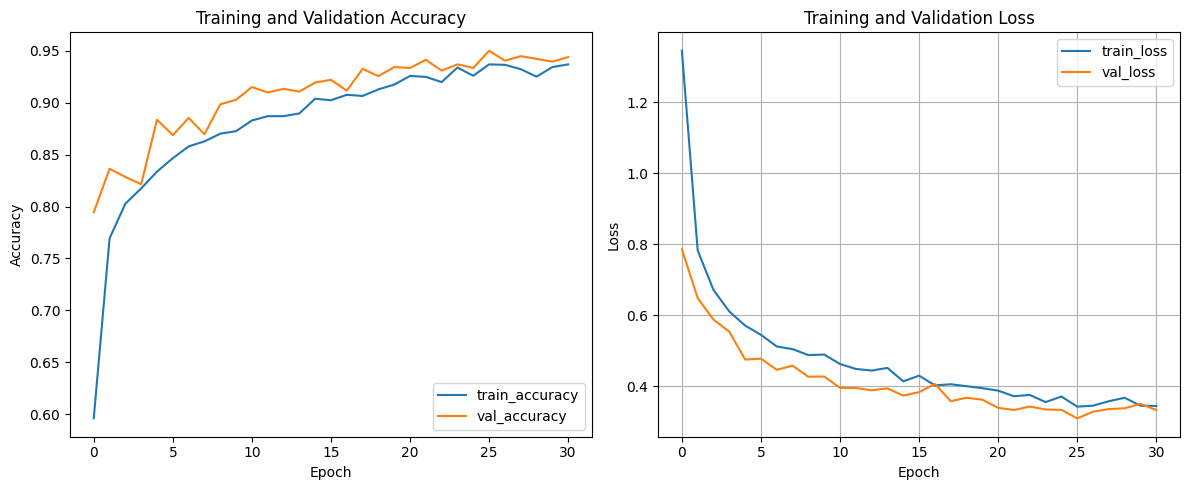


Avaliação do modelo final no conjunto de teste:
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9044 - loss: 0.4032 - precision: 0.9073 - recall: 0.9034
Loss no teste: 0.3393
Acurácia no teste: 0.9390
Precisão no teste: 0.9418
Recall no teste: 0.9382
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


AttributeError: '_PrefetchDataset' object has no attribute 'class_names'

In [48]:
# Definir o caminho do dataset
dataset_path = "/kaggle/input/brain-tumor-mri-dataset"
train_dir = os.path.join(dataset_path, "Training")
test_dir = os.path.join(dataset_path, "Testing")

# Definir o novo tamanho da imagem
IMAGE_SIZE = (64, 64)

# Coletar caminhos de imagem e rótulos do conjunto de treinamento
image_paths = []
labels = []
class_names_list = sorted(os.listdir(train_dir))
num_classes = len(class_names_list)
class_to_label = {name: i for i, name in enumerate(class_names_list)}

for class_name in class_names_list:
    class_dir = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(class_to_label[class_name])

# Converter para numpy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

# Dividir o conjunto de treino em treino e validação
# Usando 80% para treino e 20% para validação (ajustável)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Carregar o conjunto de teste separadamente
test_dataset_raw = keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMAGE_SIZE,
    batch_size=32, # Ajustar o tamanho do batch
    shuffle=False,
    label_mode='categorical') # São mais de 2 classes, então é categorical

# Pegar os nomes das classes ANTES de otimizar o dataset
class_names = test_dataset_raw.class_names

# Otimização de desempenho para o conjunto de teste
AUTOTUNE = tf.data.AUTOTUNE
test_dataset = test_dataset_raw.cache().prefetch(buffer_size=AUTOTUNE)

# Data Augmentation (opcional)
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"), # Inversão horizontal
        layers.RandomRotation(0.05),       # Rotação para até 5% (0.05 radianos)
        layers.RandomContrast(0.05),     # Ajuste de contraste (opcional)
    ],
    name="data_augmentation",
)

# Função para criar o modelo
def create_model(num_classes):
    model = keras.Sequential([
        keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        layers.Rescaling(1./255),
        layers.Conv2D(16, (3,3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2), strides=2),
        layers.Dropout(0.3),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2), strides=2),
        layers.Dropout(0.2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2), strides=2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=["accuracy",
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')])
    return model

# Função para criar datasets de treino e validação a partir de caminhos e rótulos
# Para usar o Data Augmentation: augment=True
def create_tf_dataset_split(image_paths, labels, num_classes, batch_size, shuffle=False, augment=False):
    # Função auxiliar para carregar e pré-processar imagens
    def load_image(image_path, label):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMAGE_SIZE)
        label = tf.one_hot(label, num_classes)
        return img, label

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(lambda x, y: load_image(x, y), num_parallel_calls=AUTOTUNE)
    if augment:
         dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE) # Aplica DA no treino
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
    return dataset

# Criar datasets de treino e validação
# Para usar o Data Augmentation: augment=True
train_dataset = create_tf_dataset_split(train_paths, train_labels, num_classes, batch_size=32, shuffle=True, augment=False)
val_dataset = create_tf_dataset_split(val_paths, val_labels, num_classes, batch_size=32)


# Criação e compilação do modelo final
model = create_model(num_classes)

# Early Stopping e Learning Rate para o treinamento
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

# Callback para salvar o melhor modelo
model_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/PROJETO IA 2024-2025/modelos_salvos/melhor_modelo_tumores_sem_VC.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

print("Training the model...")
history = model.fit(
    train_dataset,
    epochs=50, # Número de épocas
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr, model_checkpoint_callback])

# Plotagem dos resultados do treinamento
plt.figure(figsize=(12, 5))

# Plotar Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

# Plotar Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


# Avaliação do modelo final no conjunto de teste
print("\nAvaliação do modelo final no conjunto de teste:")
loss, accuracy, precision, recall = model.evaluate(test_dataset)
print(f"Loss no teste: {loss:.4f}")
print(f"Acurácia no teste: {accuracy:.4f}")
print(f"Precisão no teste: {precision:.4f}")
print(f"Recall no teste: {recall:.4f}")

# Geração da Matriz de Confusão
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Fazer previsões no conjunto de teste
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Obter os rótulos verdadeiros do conjunto de teste
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
# Converter os rótulos de one-hot para um único número
y_true = np.argmax(y_true, axis=1)

# 3. Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)

# 4. Plotar a matriz de confusão usando Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Matriz de Confusão')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')
plt.show()

# DANDO PREDICT NO MODELO

In [ ]:
# Pegar o nome das classes
import os

test_dir = "/kaggle/input/brain-tumor-mri-dataset/Testing"

# Listar os diretórios dentro do diretório de teste
print("Diretórios dentro de:", test_dir)
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        print(f"- {class_name}/")

In [ ]:
# Carregar o modelo treinado
model_path = '/content/drive/MyDrive/PROJETO IA 2024-2025/modelos_salvos/melhor_modelo_tumores_sem_VC.keras'
loaded_model = keras.models.load_model(model_path)

# Carregar e pré-processar uma nova imagem
def load_and_preprocess_image(image_path, image_size):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3) # Decodificar JPEG (se for outro formato, só mudar)
    img = tf.image.resize(img, image_size)
    img = tf.expand_dims(img, axis=0)
    return img

# Caminho para a imagem que quer prever
new_image_path = '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/glioma/G_108.jpg'

# Definir o tamanho da imagem (deve ser o mesmo tamanho usado no treinamento)
IMAGE_SIZE_PREDICT = (64, 64)

# Carregar e pré-processar a nova imagem
new_image = load_and_preprocess_image(new_image_path, IMAGE_SIZE_PREDICT)

# Fazer a previsão
predictions = loaded_model.predict(new_image)
predicted_class_index = np.argmax(predictions)

# Mapear o índice previsto de volta para o nome da classe
class_names = sorted(os.listdir("/kaggle/input/brain-tumor-mri-dataset/Training"))
predicted_class_name = class_names[predicted_class_index]

print(f"A imagem é prevista como: {predicted_class_name}")

# Plotar as previsões em um gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(class_names, predictions[0])
plt.xlabel("Classes")
plt.ylabel("Probabilidade")
plt.title("Probabilidade de Previsão por Classe")
plt.ylim(0, 1) # Definir o limite do eixo y entre 0 e 1
plt.show()

**Como usar:**

1.  **Atualize os caminhos:** Substitua o valor de `model_path` pelo caminho real do seu modelo salvo no Google Drive. Substitua o valor de `new_image_path` pelo caminho da imagem que você deseja prever.
2.  **Verifique `IMAGE_SIZE_PREDICT`:** Certifique-se de que `IMAGE_SIZE_PREDICT` é o mesmo tamanho de imagem que você usou durante o treinamento do modelo.
3.  **Verifique `class_names`:** Se a variável `class_names` não estiver definida globalmente, descomente e execute a linha que a define a partir do diretório "Training" para que o código possa mapear o índice previsto para o nome da classe.
4.  **Execute a célula:** Execute a célula de código para obter a previsão.

In [50]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 957,422 (3.65 MB)

 Trainable params: 319,140 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 638,282 (2.43 MB)